In [1]:
import pandas as pd
import numpy as np
import pyodbc
import json
#from google.cloud import bigquery
from pandas.io import gbq
from datetime import datetime
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Table, create_engine
from sqlalchemy.orm import sessionmaker


from statsmodels.stats.weightstats import ztest as ztest
from statsmodels.stats.stattools import durbin_watson
import sqlalchemy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline
import random
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


import seaborn as sns
import plotly.express as px

import scipy 
from scipy.stats import iqr
from scipy.stats import norm
from scipy.stats import t
from scipy import stats

import math

In [2]:
password = 'dimVuidBun1onCub'
login = 'a.al.kosheleva'

In [3]:
def postre_auth(login, password):
    postgresql_config = {
    'postgresql_prefix' : 'postgresql'
    , 'postgresql_host'   : '172.24.25.7' 
    , 'postgresql_user'   : f'{login}'
    , 'postgresql_pass'   : f'{password}'
    , 'postgresql_port'   : '5432'
    , 'postgresql_db'     : 'dwh'    
    }

    postgresql_connection_string  = "{prefix}://{user}:{passw}@{host}:{port}/{db}".format(
    prefix  =   postgresql_config['postgresql_prefix']    , host  =   postgresql_config['postgresql_host']
    , user  =   postgresql_config['postgresql_user']      , passw =   postgresql_config['postgresql_pass']
    , port  =   postgresql_config['postgresql_port']      , db    =   postgresql_config['postgresql_db']
    )
    postgresql_engine = sqlalchemy.create_engine(postgresql_connection_string)
    postgresql_conn   = postgresql_engine.connect()
    return postgresql_engine, postgresql_conn

postrgre_engine, postrge_conn = postre_auth(login, password)

In [5]:
tk_test  = '''
'ТК655',
'ТК296',
'ТК607',
'ТК639',
'ТК116',
'ТК298',
'ТК183',
'ТК1421',
'ТК1324',
'ТК601',
'ТК160',
'ТК201',
'ТК667',
'ТК196',
'ТК302',
'ТК260',
'ТК168',
'ТК1337',
'ТК142'
'''

tk_control = '''
'ТК130',
'ТК27',
'ТК108',
'ТК29',
'ТК292',
'ТК175',
'ТК293',
'ТК1316',
'ТК603',
'ТК169',
'ТК1322',
'ТК1340',
'ТК277',
'ТК128',
'ТК291',
'ТК1422',
'ТК295',
'ТК656',
'ТК150'
'''

l_test = [
'ТК655',
'ТК296',
'ТК607',
'ТК639',
'ТК116',
'ТК298',
'ТК183',
'ТК1421',
'ТК1324',
'ТК601',
'ТК160',
'ТК201',
'ТК667',
'ТК196',
'ТК302',
'ТК260',
'ТК168',
'ТК1337',
'ТК142']

l_contrl = [
'ТК130',
'ТК27',
'ТК108',
'ТК29',
'ТК292',
'ТК175',
'ТК293',
'ТК1316',
'ТК603',
'ТК169',
'ТК1322',
'ТК1340',
'ТК277',
'ТК128',
'ТК291',
'ТК1422',
'ТК295',
'ТК656',
'ТК150']

In [6]:
date_start = '2023-01-16'
date_end = '2023-01-20'
ab_name = 'СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20'

In [7]:
control = f'''
select distinct DATE_PART('week', date) AS week,
    count(distinct buyer_id) AS buyers,
    count(distinct o.pav_order_id) AS orders,
    round(sum(bill_amount),0) AS revenue,
    round(sum(bill_amount) / count(distinct o.pav_order_id),0) AS avg_check,
    round(sum(margin),0) AS margin
    from dwh_datamart.ops_metrics o
    left join dwh_datamart.receipts c ON o.pav_order_id = (CASE WHEN zinstype = 'Y2' THEN substr(zdocnecom, 7, 18) ELSE substr(zdocnecom, 9, 18) END)
    where  ((date between date('{date_start}') AND date('{date_end}'))
    or (o.date between date ('{date_start}') - interval '1 week' AND date ('{date_end}') - interval '1 week'))
    AND flag_cancel = 0
    AND order_source IN ('iOS', 'Android')
    AND retail_brand = 'lo'
    AND o.hub_name IN (
{tk_control}
)
group by 1
order by 1
'''

In [8]:
df_control = pd.read_sql(control, postrge_conn)

In [9]:
df_control

,week,buyers,orders,revenue,avg_check,margin
0,2.0,39952,44879,104205673.0,2322.0,22787132.0
1,3.0,37221,41702,95055492.0,2279.0,20466315.0


In [10]:
test = f'''
select distinct DATE_PART('week', date) AS week,
    count(distinct buyer_id) AS buyers,
    count(distinct o.pav_order_id) AS orders,
    round(sum(bill_amount),0) AS revenue,
    round(sum(bill_amount) / count(distinct o.pav_order_id),0) AS avg_check,
    round(sum(margin),0) AS margin
    from dwh_datamart.ops_metrics o
    left join dwh_datamart.receipts c ON o.pav_order_id = (CASE WHEN zinstype = 'Y2' THEN substr(zdocnecom, 7, 18) ELSE substr(zdocnecom, 9, 18) END)
    where  ((date between date('{date_start}') AND date('{date_end}'))
    or (o.date between date ('{date_start}') - interval '1 week' AND date ('{date_end}') - interval '1 week'))
    AND flag_cancel = 0
    AND order_source IN ('iOS', 'Android')
    AND retail_brand = 'lo'
    AND o.hub_name IN (
{tk_test}
)
group by 1
order by 1
'''

In [11]:
df_test = pd.read_sql(test, postrge_conn)
df_test

,week,buyers,orders,revenue,avg_check,margin
0,2.0,41973,47377,109297355.0,2307.0,24176989.0
1,3.0,39119,43809,98970030.0,2259.0,21525939.0


In [12]:
df_test_final = df_test.T.rename(columns={0: "week_before_test", 1: "week_after_test"}).drop(index='week').reset_index()
df_test_final['difference_test'] = df_test_final['week_after_test']/df_test_final['week_before_test']*100-100

df_control_final = df_control.T.rename(columns={0: "week_before_control", 1: "week_after_control"}).drop(index='week').reset_index()
df_control_final['difference_control'] = df_control_final['week_after_control']/df_control_final['week_before_control']*100-100
df_final = df_control_final.merge(df_test_final, on = 'index', how = 'inner')

df_final['diff_in_diff'] = df_final['difference_test'] - df_final['difference_control']
df_final['ab_test_name'] = ab_name
df_final['index'] = df_final['index'].map({'buyers': 'Количество_покупателей', 'orders': 'Количество_заказов', 'revenue': 'Выручка', 'avg_check': 'Средний_чек', 'margin': 'Абс.маржа'})
df_final

,index,week_before_control,week_after_control,difference_control,week_before_test,week_after_test,difference_test,diff_in_diff,ab_test_name
0,Количество_покупателей,39952.0,37221.0,-6.835703,41973.0,39119.0,-6.799609,0.036094,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
1,Количество_заказов,44879.0,41702.0,-7.079035,47377.0,43809.0,-7.531080,-0.452046,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
2,Выручка,104205673.0,95055492.0,-8.780886,109297355.0,98970030.0,-9.448833,-0.667948,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
3,Средний_чек,2322.0,2279.0,-1.851852,2307.0,2259.0,-2.080624,-0.228772,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
4,Абс.маржа,22787132.0,20466315.0,-10.184770,24176989.0,21525939.0,-10.965179,-0.780408,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20


In [13]:
#df_final.to_excel('geo_ab_table.xlsx')

Далее приведен код для бутстрапа

In [13]:
pilot = f'''
select distinct hub_name,
    CASE WHEN
        hub_name IN (
  {tk_control}) THEN 'control'
  ELSE 'test' END AS hub_group,
    count(distinct buyer_id) AS buyers,
    count(distinct o.pav_order_id) AS orders,
    sum(bill_amount) AS revenue,
    sum(bill_amount) / count(distinct o.pav_order_id) AS avg_check,
    sum(margin) AS total_margin
    from dwh_datamart.ops_metrics o
    left join dwh_datamart.receipts c ON o.pav_order_id = (CASE WHEN zinstype = 'Y2' THEN substr(zdocnecom, 7, 18) ELSE substr(zdocnecom, 9, 18) END)
    where flag_cancel = 0
    AND retail_brand = 'lo'
    AND order_source IN ('iOS', 'Android')
    AND (date between '{date_start}' AND '{date_end}')
    AND hub_name IN ({tk_control}, {tk_test})
group by 1,2
'''

In [14]:
df_pilot = pd.read_sql(pilot, postrge_conn)

In [15]:
df_pilot.head()

,hub_name,hub_group,buyers,orders,revenue,avg_check,total_margin
0,ТК1,control,315,342,778621.01,2276.669620,178699.57
1,ТК10,test,674,783,2077955.66,2653.838646,530224.38
2,ТК100,control,496,582,1492175.23,2563.874966,359775.17
3,ТК108,control,251,284,811545.53,2857.554683,186710.33
4,ТК109,test,188,204,471841.08,2312.946471,98172.79


In [16]:
before = f'''
select distinct hub_name,
    CASE WHEN
        hub_name IN (
  {tk_control}) THEN 'control'
  ELSE 'test' END AS hub_group,
    count(distinct buyer_id) AS buyers,
    count(distinct o.pav_order_id) AS orders,
    sum(bill_amount) AS revenue,
    sum(bill_amount) / count(distinct o.pav_order_id) AS avg_check,
    sum(margin) AS total_margin
    from dwh_datamart.ops_metrics o
    left join dwh_datamart.receipts c ON o.pav_order_id = (CASE WHEN zinstype = 'Y2' THEN substr(zdocnecom, 7, 18) ELSE substr(zdocnecom, 9, 18) END)
    where flag_cancel = 0
    AND retail_brand = 'lo'
    AND order_source IN ('iOS', 'Android')
    AND (date between date ('{date_start}') - interval '1 week' AND date ('{date_end}') - interval '1 week')
    AND hub_name IN ({tk_control}, {tk_test})
group by 1,2
'''

In [17]:
df_before = pd.read_sql(before, postrge_conn)

In [18]:
df_before.head()

,hub_name,hub_group,buyers,orders,revenue,avg_check,total_margin
0,ТК1,control,357,403,931464.73,2311.326873,213334.53
1,ТК10,test,766,912,2272010.11,2491.239156,583640.42
2,ТК100,control,510,582,1434003.04,2463.922749,349352.60
3,ТК108,control,244,285,858162.41,3011.096175,203646.61
4,ТК109,test,220,245,627369.60,2560.692245,125554.59


In [19]:
#преподготовка данных
df_before_control = df_before[df_before['hub_group'] =='control']
df_before_test = df_before[df_before['hub_group'] =='test']

df_pilot_control = df_pilot[df_pilot['hub_group'] =='control']
df_pilot_test = df_pilot[df_pilot['hub_group'] =='test']

In [20]:
# бутстрап выборки:
def get_bootstrap_samples(data, n_samples):
    ind = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[ind]
    return samples

# ДИ на бутстрапированных данных:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 50, 100 * (1 - alpha / 2.)])
    return boundaries

def merge_data(data1, data2, col):
    df_before = data1.add_prefix('before_').copy()
    df_after = data2.add_prefix('after_').copy()
    df_merged = df_before.merge(df_after, how = 'left', left_on = 'before_hub_name', right_on = 'after_hub_name').dropna()
    
    list_cols_a = []
    [list_cols_a.append(i) for i in df_merged.columns if col in i and 'after' in i]
    df_after = df_merged[list_cols_a].iloc[:,0]
    
    list_cols_b = []
    [list_cols_b.append(i) for i in df_merged.columns if col in i and 'before' in i]
    df_before = df_merged[list_cols_b].iloc[:,0]
    
    
    return df_after / df_before - 1
    #return df_merged

In [21]:
def get_did_intervals(df_before_control, df_pilot_control, df_before_test, df_pilot_test, metric = 'revenue'):
    a = merge_data(df_before_control, df_pilot_control, metric).values
    b = merge_data(df_before_test, df_pilot_test, metric).values

    list_a_means = [i for i in map(np.mean, get_bootstrap_samples(a, 1000))]
    list_b_means = [i for i in map(np.mean, get_bootstrap_samples(b, 1000))]

    list_uplifts_abs = np.array([i for i in map(lambda x: x[1] - x[0], zip(list_a_means, list_b_means))])

    ci_05 = stat_intervals(list_uplifts_abs, 0.05)
    ci_10 = stat_intervals(list_uplifts_abs, 0.1)
    
    return ci_05    

In [22]:
#посчитаем доверительный интервал DID для всех метрик
ci_05_revenue = get_did_intervals(df_before_control, df_pilot_control, df_before_test, df_pilot_test, metric = 'revenue')
ci_05_margin = get_did_intervals(df_before_control, df_pilot_control, df_before_test, df_pilot_test, metric = 'margin')
ci_05_check = get_did_intervals(df_before_control, df_pilot_control, df_before_test, df_pilot_test, metric = 'avg_check')
ci_05_buyers = get_did_intervals(df_before_control, df_pilot_control, df_before_test, df_pilot_test, metric = 'buyers')
ci_05_orders = get_did_intervals(df_before_control, df_pilot_control, df_before_test, df_pilot_test, metric = 'orders')

In [23]:
revenue = pd.DataFrame(ci_05_revenue).rename(columns={0: "revenue"}).reset_index()
check = pd.DataFrame(ci_05_check).rename(columns={0: "check"}).reset_index()
buyers = pd.DataFrame(ci_05_buyers).rename(columns={0: "buyers"}).reset_index()
orders = pd.DataFrame(ci_05_orders).rename(columns={0: "orders"}).reset_index()
margin = pd.DataFrame(ci_05_margin).rename(columns={0: "margin"}).reset_index()
from functools import reduce
data_frames = [revenue, check, buyers, orders, margin]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['index'], how='inner'), data_frames)                                        

In [24]:
df_merged = df_merged[['index', 'revenue', 'check', 'buyers', 'orders', 'margin']]
df_merged["index"] = df_merged["index"].apply(lambda x: 'DID_percentile_2_5' if x == 0 else 'DID_percentile_50' if x == 1 else 'DID_percentile_97_5')
df_merged = df_merged.T.reset_index()

df_merged = df_merged.drop(df_merged.index[0])
df_merged = df_merged.rename(columns={0: "DID_percentile_2_5", 1: "DID_percentile_50", 2: "DID_percentile_97_5"})
df_merged['ab_test_name'] = ab_name
df_merged['index'] = df_merged['index'].map({'buyers': 'Количество_покупателей', 'orders': 'Количество_заказов', 'revenue': 'Выручка', 'check': 'Средний_чек', 'margin': 'Абс.маржа'})

In [25]:
did_results = df_merged
did_results

,index,DID_percentile_2_5,DID_percentile_50,DID_percentile_97_5,ab_test_name
1,Выручка,-0.0266765,0.003687,0.0325337,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
2,Средний_чек,-0.0174059,-0.0020584,0.0145298,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
3,Количество_покупателей,-0.0188639,0.00965064,0.0422521,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
4,Количество_заказов,-0.0259799,0.00395927,0.0354296,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
5,Абс.маржа,-0.027355,0.00546113,0.0394695,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20


Теперь часть с регрессией

In [26]:
#вытянем данные по периоду усиления (пилотному) с группировкой по дате и группе тест-контроль
pilot = f'''
select distinct date,
    CASE WHEN
        o.hub_name IN (
  {tk_control}) THEN 'control'
  ELSE 'test' END AS hub_group,
  'pilot' AS period,
    count(distinct buyer_id) AS buyers,
    count(distinct o.pav_order_id) AS orders,
    sum(bill_amount) AS revenue,
    sum(bill_amount) / count(distinct o.pav_order_id) AS avg_check,
    sum(margin) AS total_margin
    from dwh_datamart.ops_metrics o
    left join dwh_datamart.receipts c ON o.pav_order_id = (CASE WHEN zinstype = 'Y2' THEN substr(zdocnecom, 7, 18) ELSE substr(zdocnecom, 9, 18) END)
    left join dwh_stage.manual_geo g ON o.hub_name = g.hub_name
    where flag_cancel = 0
    AND retail_brand = 'lo'
    AND order_source IN ('iOS', 'Android')
    AND (date between '{date_start}' AND '{date_end}')
    AND o.hub_name IN (
    {tk_control}, {tk_test})
group by 1,2
'''

In [27]:
df_pilot = pd.read_sql(pilot, postrge_conn)
df_pilot

,date,hub_group,period,buyers,orders,revenue,avg_check,total_margin
0,2023-01-16,control,pilot,7193,7288,16165949.39,2218.159905,3631731.67
1,2023-01-16,test,pilot,7687,7796,17392728.75,2230.981112,3981768.59
2,2023-01-17,control,pilot,7366,7520,16798803.46,2233.883439,3753586.40
3,2023-01-17,test,pilot,7867,7977,17566023.02,2202.083869,3988529.77
4,2023-01-18,control,pilot,7740,7819,17709039.68,2264.872705,3984005.93
5,2023-01-18,test,pilot,8172,8279,18522613.79,2237.300856,4174283.52
6,2023-01-19,control,pilot,8173,8274,19007863.01,2297.300340,4138677.90
7,2023-01-19,test,pilot,8549,8651,19621906.93,2268.166331,4282302.64
8,2023-01-20,control,pilot,10706,10801,25373836.16,2349.211754,4958313.05
9,2023-01-20,test,pilot,10962,11106,25866757.85,2329.079583,5099054.42


In [28]:
#теперь по предпилотному периоду длиной в месяц с той же группировкой
before = f'''
select distinct date,
    CASE WHEN
        o.hub_name IN (
  {tk_control}) THEN 'control'
  ELSE 'test' END AS hub_group,
  'pilot' AS period,
    count(distinct buyer_id) AS buyers,
    count(distinct o.pav_order_id) AS orders,
    sum(bill_amount) AS revenue,
    sum(bill_amount) / count(distinct o.pav_order_id) AS avg_check,
    sum(margin) AS total_margin
    from dwh_datamart.ops_metrics o
    left join dwh_datamart.receipts c ON o.pav_order_id = (CASE WHEN zinstype = 'Y2' THEN substr(zdocnecom, 7, 18) ELSE substr(zdocnecom, 9, 18) END)
    left join dwh_stage.manual_geo g ON o.hub_name = g.hub_name
    where flag_cancel = 0
    AND retail_brand = 'lo'
    AND order_source IN ('iOS', 'Android')
    AND (date between date ('{date_start}') - interval '1 week' AND date ('{date_end}') - interval '1 week')
    AND o.hub_name IN (
    {tk_control}, {tk_test})
group by 1,2
'''

In [29]:
df_prepilot = pd.read_sql(before, postrge_conn)
df_prepilot.head()

,date,hub_group,period,buyers,orders,revenue,avg_check,total_margin
0,2023-01-09,control,pilot,8035,8140,18077880.45,2220.869834,3988002.11
1,2023-01-09,test,pilot,8498,8633,19392574.33,2246.330862,4416784.25
2,2023-01-10,control,pilot,8601,8688,19855550.47,2285.399456,4456977.06
3,2023-01-10,test,pilot,8981,9120,20477773.25,2245.369874,4634050.39
4,2023-01-11,control,pilot,8826,8933,20564762.06,2302.111503,4581391.73


In [30]:
#соединим в 1
final_table = pd.concat([df_prepilot, df_pilot])
#отберем нужные столбцы, протестим нашу регрессию на каждой метрике поочередно
final_table_regr = final_table[['date','hub_group', 'period', 'orders','buyers', 'revenue', 'avg_check', 'total_margin']]

control_table = final_table_regr[final_table_regr['hub_group'] == 'control']
test_table = final_table_regr[final_table_regr['hub_group'] == 'test']
test_and_control = test_table.merge(control_table, how = 'inner', on = ['date', 'period'], suffixes=('_test', '_control'))

test_and_control.isna().sum()

date                    0
hub_group_test          0
period                  0
orders_test             0
buyers_test             0
revenue_test            0
avg_check_test          0
total_margin_test       0
hub_group_control       0
orders_control          0
buyers_control          0
revenue_control         0
avg_check_control       0
total_margin_control    0
dtype: int64

In [31]:
#предподготовка данных почти завершена
test_and_control_final = test_and_control.drop(columns=['hub_group_test', 'hub_group_control'])
test_and_control_final.head()

,date,period,orders_test,buyers_test,revenue_test,avg_check_test,total_margin_test,orders_control,buyers_control,revenue_control,avg_check_control,total_margin_control
0,2023-01-09,pilot,8633,8498,19392574.33,2246.330862,4416784.25,8140,8035,18077880.45,2220.869834,3988002.11
1,2023-01-10,pilot,9120,8981,20477773.25,2245.369874,4634050.39,8688,8601,19855550.47,2285.399456,4456977.06
2,2023-01-11,pilot,9525,9353,21695630.21,2277.756452,4783141.88,8933,8826,20564762.06,2302.111503,4581391.73
3,2023-01-12,pilot,9620,9437,22429121.45,2331.509506,4831889.40,9016,8873,21088912.93,2339.054229,4472920.29
4,2023-01-13,pilot,10479,10304,25302255.47,2414.567752,5511122.98,10102,9955,24618566.71,2436.999278,5287840.46


<AxesSubplot:xlabel='orders_test', ylabel='orders_control'>

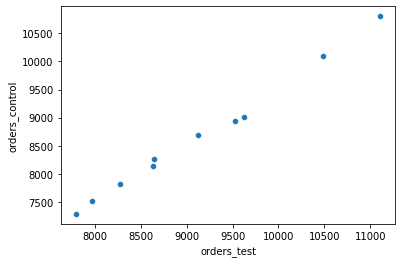

In [32]:
#визуализируем связь между метриками в тесте и контроле чтобы убедиться, что использование лин.регрессии тут ок
sns.scatterplot(data=test_and_control_final, x="orders_test", y="orders_control")

<AxesSubplot:xlabel='buyers_test', ylabel='buyers_control'>

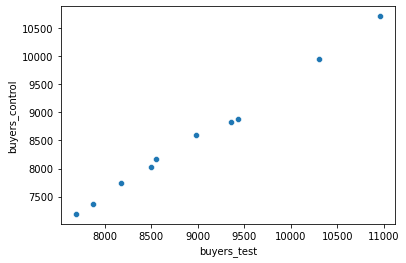

In [33]:
sns.scatterplot(data=test_and_control_final, x="buyers_test", y="buyers_control")

<AxesSubplot:xlabel='revenue_test', ylabel='revenue_control'>

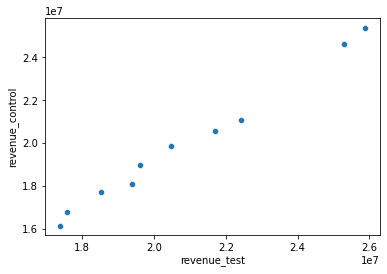

In [34]:
sns.scatterplot(data=test_and_control_final, x="revenue_test", y="revenue_control")

<AxesSubplot:xlabel='total_margin_test', ylabel='total_margin_control'>

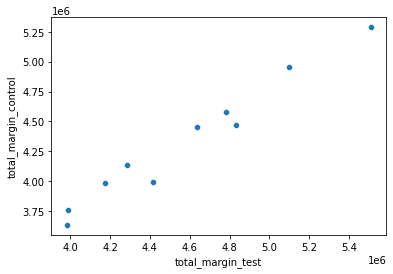

In [35]:
sns.scatterplot(data=test_and_control_final, x="total_margin_test", y="total_margin_control")

<AxesSubplot:xlabel='avg_check_test', ylabel='avg_check_control'>

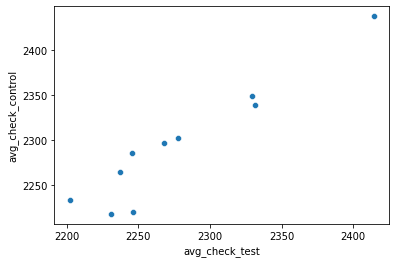

In [36]:
#для среднего чека возможно будет не так хорошо
sns.scatterplot(data=test_and_control_final, x="avg_check_test", y="avg_check_control")

In [37]:
column_headers = list(test_and_control_final.columns.values)

In [38]:
#логарифмируем наши переменные чтобы смотреть на изменение в %
def get_log_df(data):
    def log_transform(v): 
        res = np.log(v)
        return res
    
    data_tmp = data.copy()
    for el in ['orders_test',
 'buyers_test',
 'revenue_test',
 'avg_check_test',
 'total_margin_test']:
        data_tmp[el] = data_tmp[el].apply(lambda x: log_transform(x))
    return data_tmp

df_log = get_log_df(test_and_control_final.copy())
test_and_control_final = df_log

#перекодируем переменную период в дамми-переменную
test_and_control_final["period"] = test_and_control_final['period'].apply(lambda x: 0 if x == 'pre_pilot' else 1)

test_and_control_final.head()

,date,period,orders_test,buyers_test,revenue_test,avg_check_test,total_margin_test,orders_control,buyers_control,revenue_control,avg_check_control,total_margin_control
0,2023-01-09,1,9.063347,9.047586,16.780401,7.717053,15.300922,8140,8035,18077880.45,2220.869834,3988002.11
1,2023-01-10,1,9.118225,9.102867,16.834851,7.716626,15.348942,8688,8601,19855550.47,2285.399456,4456977.06
2,2023-01-11,1,9.161675,9.143452,16.892621,7.730946,15.380608,8933,8826,20564762.06,2302.111503,4581391.73
3,2023-01-12,1,9.171600,9.152393,16.925871,7.754271,15.390748,9016,8873,21088912.93,2339.054229,4472920.29
4,2023-01-13,1,9.257129,9.240287,17.046404,7.789276,15.522279,10102,9955,24618566.71,2436.999278,5287840.46


In [39]:
#посчитаем коэффициент вздутия дисперсии чтобы избежать мультиколлинеарности 
#from statsmodels.stats.outliers_influence import variance_inflation_factor
#from statsmodels.tools.tools import add_constant
#df = test_and_control_final.copy()
#df = df[['orders_test', 'orders_control', 'period']]
#X = add_constant(df)
#pd.Series([variance_inflation_factor(X.values, i) 
               #for i in range(X.shape[1])], 
              #index=X.columns)

In [40]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

In [41]:
#здесь уже используем устойчивые к гетероскедастичности ошибки
y = test_and_control_final['orders_test']
x = test_and_control_final[['orders_control','period']]
x = sm.add_constant(x)  
model = sm.OLS(y, x)
results = model.fit(cov_type='HC3') 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            orders_test   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     200.1
Date:                Mon, 23 Jan 2023   Prob (F-statistic):           6.07e-07
Time:                        07:36:41   Log-Likelihood:                 29.545
No. Observations:                  10   AIC:                            -55.09
Df Residuals:                       8   BIC:                            -54.49
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
orders_control     0.0001   7.28e-06     14.

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1604: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



In [42]:
#закинем все нужные показатели в табличку чтобы потом собрать ее по всем показателям
ols_orders = pd.DataFrame([results.params.period, results.params.orders_control, \
                results.pvalues.loc['period'], results.pvalues.loc['orders_control'], \
                results.rsquared_adj, results.f_pvalue,
                stats.shapiro(results.resid).pvalue,
                durbin_watson(results.resid),
                stat_intervals(results.resid, 0.05)[0], stat_intervals(results.resid, 0.05)[2]
               ]).rename(columns={0: "orders"}).reset_index()

In [43]:
#теперь то же самое прогоним для количества покупателей
#заранее уже используем устойчивые к гетероскедастичности ошибки
y = test_and_control_final['buyers_test']
x = test_and_control_final[['buyers_control','period']]
x = sm.add_constant(x)  
model = sm.OLS(y, x)
results = model.fit(cov_type='HC3') 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            buyers_test   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     216.3
Date:                Mon, 23 Jan 2023   Prob (F-statistic):           4.49e-07
Time:                        07:36:53   Log-Likelihood:                 30.625
No. Observations:                  10   AIC:                            -57.25
Df Residuals:                       8   BIC:                            -56.64
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
buyers_control     0.0001   6.98e-06     14.

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1604: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



In [44]:
ols_buyers = pd.DataFrame([results.params.period, results.params.buyers_control, \
                results.pvalues.loc['period'], results.pvalues.loc['buyers_control'], \
                results.rsquared_adj, results.f_pvalue,
                stats.shapiro(results.resid).pvalue,
                durbin_watson(results.resid),
                stat_intervals(results.resid, 0.05)[0], stat_intervals(results.resid, 0.05)[2]
               ]).rename(columns={0: "buyers"}).reset_index()

In [45]:
#теперь построим для выручки
y = test_and_control_final['revenue_test']
x = test_and_control_final[['revenue_control','period']]
x = sm.add_constant(x)  
model = sm.OLS(y, x)
results = model.fit(cov_type='HC3') 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           revenue_test   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     342.6
Date:                Mon, 23 Jan 2023   Prob (F-statistic):           7.48e-08
Time:                        07:36:57   Log-Likelihood:                 26.613
No. Observations:                  10   AIC:                            -49.23
Df Residuals:                       8   BIC:                            -48.62
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
revenue_control  4.464e-08   2.41e-09     

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1604: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



In [46]:
ols_revenue = pd.DataFrame([results.params.period, results.params.revenue_control, \
                results.pvalues.loc['period'], results.pvalues.loc['revenue_control'], \
                results.rsquared_adj, results.f_pvalue,
                stats.shapiro(results.resid).pvalue,
                durbin_watson(results.resid),
                stat_intervals(results.resid, 0.05)[0], stat_intervals(results.resid, 0.05)[2]
               ]).rename(columns={0: "revenue"}).reset_index()

In [47]:
#теперь построим для маржи
y = test_and_control_final['total_margin_test']
x = test_and_control_final[['total_margin_control','period']]
x = sm.add_constant(x)  
model = sm.OLS(y, x)
results = model.fit(cov_type='HC3') 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      total_margin_test   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     405.7
Date:                Mon, 23 Jan 2023   Prob (F-statistic):           3.85e-08
Time:                        07:37:01   Log-Likelihood:                 25.221
No. Observations:                  10   AIC:                            -46.44
Df Residuals:                       8   BIC:                            -45.84
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
total_margin_control  1.993e-07 

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1604: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



In [48]:
ols_margin = pd.DataFrame([results.params.period, results.params.total_margin_control, \
                results.pvalues.loc['period'], results.pvalues.loc['total_margin_control'], \
                results.rsquared_adj, results.f_pvalue,
                stats.shapiro(results.resid).pvalue,
                durbin_watson(results.resid),
                stat_intervals(results.resid, 0.05)[0], stat_intervals(results.resid, 0.05)[2]
               ]).rename(columns={0: "margin"}).reset_index()

In [49]:
#теперь построим для среднего чека
y = test_and_control_final['avg_check_test']
x = test_and_control_final[['avg_check_control','period']]
x = sm.add_constant(x)  
model = sm.OLS(y, x)
results = model.fit(cov_type='HC3') 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         avg_check_test   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     48.54
Date:                Mon, 23 Jan 2023   Prob (F-statistic):           0.000116
Time:                        07:37:07   Log-Likelihood:                 34.093
No. Observations:                  10   AIC:                            -64.19
Df Residuals:                       8   BIC:                            -63.58
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
avg_check_control     0.0004   5.53e-0

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1604: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



In [50]:
ols_check = pd.DataFrame([results.params.period, results.params.avg_check_control, \
                results.pvalues.loc['period'], results.pvalues.loc['avg_check_control'], \
                results.rsquared_adj, results.f_pvalue,
                stats.shapiro(results.resid).pvalue,
                durbin_watson(results.resid),
                stat_intervals(results.resid, 0.05)[0], stat_intervals(results.resid, 0.05)[2]
               ]).rename(columns={0: "check"}).reset_index()

In [51]:
#соберем нужные нам коэффициенты в табличку
from functools import reduce
data_frames = [ols_revenue, ols_check, ols_buyers, ols_orders, ols_margin]
df_merged_regression = reduce(lambda  left,right: pd.merge(left,right,on=['index'], how='inner'), data_frames)

In [52]:
df_merged_regression

,index,revenue,check,buyers,orders,margin
0,0,1.595327e+01,6.847359e+00,8.219058e+00,8.220130e+00,1.446781e+01
1,1,4.464295e-08,3.849995e-04,1.027046e-04,1.030076e-04,1.993051e-07
2,2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,3,1.733230e-76,3.233518e-12,5.936969e-49,2.004713e-45,3.206632e-90
4,4,9.816697e-01,8.933518e-01,9.878392e-01,9.851179e-01,9.588803e-01
5,5,7.481318e-08,1.163960e-04,4.493164e-07,6.068409e-07,3.854583e-08
6,6,1.458481e-01,7.431820e-01,2.844830e-01,2.284059e-01,1.304791e-01
7,7,1.165327e+00,1.939903e+00,8.741937e-01,7.703533e-01,1.262245e+00
8,8,-2.080222e-02,-1.052876e-02,-1.509612e-02,-1.588995e-02,-2.147619e-02
9,9,2.891221e-02,1.335231e-02,2.111231e-02,2.244301e-02,3.675284e-02


In [53]:
df_merged_regression["index"] = df_merged_regression["index"].apply(lambda x: '0_OLS_period_Beta_coefficient' if x == 0 else '2_OLS_control_Beta_coefficient' if x == 1 
                                                                    else '1_OLS_period_Pvalue' if x == 2
                                                                    else '3_OLS_control_Pvalue' if x == 3
                                                                    else '4_OLS_R2_adjusted' if x == 4
                                                                    else '5_OLS_F_pvalue' if x == 5
                                                                    else '7_OLS_Shapiro_test' if x == 6
                                                                    else '6_OLS_Durbin_Watson' if x == 7
                                                                    else '8_OLS_CI_2.5_for_residuals' if x == 8
                                                                    else '9_OLS_CI_97.5_for_residuals')
df_merged_regression['ab_test_name'] = ab_name

In [54]:
df_merged_regression

,index,revenue,check,buyers,orders,margin,ab_test_name
0,0_OLS_period_Beta_coefficient,1.595327e+01,6.847359e+00,8.219058e+00,8.220130e+00,1.446781e+01,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
1,2_OLS_control_Beta_coefficient,4.464295e-08,3.849995e-04,1.027046e-04,1.030076e-04,1.993051e-07,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
2,1_OLS_period_Pvalue,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
3,3_OLS_control_Pvalue,1.733230e-76,3.233518e-12,5.936969e-49,2.004713e-45,3.206632e-90,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
4,4_OLS_R2_adjusted,9.816697e-01,8.933518e-01,9.878392e-01,9.851179e-01,9.588803e-01,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
5,5_OLS_F_pvalue,7.481318e-08,1.163960e-04,4.493164e-07,6.068409e-07,3.854583e-08,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
6,7_OLS_Shapiro_test,1.458481e-01,7.431820e-01,2.844830e-01,2.284059e-01,1.304791e-01,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
7,6_OLS_Durbin_Watson,1.165327e+00,1.939903e+00,8.741937e-01,7.703533e-01,1.262245e+00,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
8,8_OLS_CI_2.5_for_residuals,-2.080222e-02,-1.052876e-02,-1.509612e-02,-1.588995e-02,-2.147619e-02,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
9,9_OLS_CI_97.5_for_residuals,2.891221e-02,1.335231e-02,2.111231e-02,2.244301e-02,3.675284e-02,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20


In [55]:
#Теперь для оценки методом прогноза

In [56]:
pilot = f'''
select distinct date, hub_name,
    count(distinct buyer_id) AS buyers,
    count(distinct o.pav_order_id) AS orders,
    sum(bill_amount) AS revenue,
    sum(bill_amount) / count(distinct o.pav_order_id) AS avg_check,
    sum(margin) AS total_margin
    from dwh_datamart.ops_metrics o
    left join dwh_datamart.receipts c ON o.pav_order_id = (CASE WHEN zinstype = 'Y2' THEN substr(zdocnecom, 7, 18) ELSE substr(zdocnecom, 9, 18) END)
    where flag_cancel = 0
    AND retail_brand = 'lo'
    AND order_source IN ('iOS', 'Android')
    AND (date between '{date_start}' AND '{date_end}')
    AND hub_name IN (
    {tk_control}, {tk_test})
group by 1,2
'''
df_pilot = pd.read_sql(pilot, postrge_conn)

In [57]:
before = f'''
select distinct date, hub_name,
    count(distinct buyer_id) AS buyers,
    count(distinct o.pav_order_id) AS orders,
    sum(bill_amount) AS revenue,
    sum(bill_amount) / count(distinct o.pav_order_id) AS avg_check,
    sum(margin) AS total_margin
    from dwh_datamart.ops_metrics o
    left join dwh_datamart.receipts c ON o.pav_order_id = (CASE WHEN zinstype = 'Y2' THEN substr(zdocnecom, 7, 18) ELSE substr(zdocnecom, 9, 18) END)
    where flag_cancel = 0
    AND retail_brand = 'lo'
    AND order_source IN ('iOS', 'Android')
    AND (date between date ('{date_start}') - interval '1 month' AND date ('{date_end}') - interval '1 month')
    AND hub_name IN (
    {tk_control}, {tk_test})
group by 1,2
'''
df_prepilot = pd.read_sql(before, postrge_conn)

In [58]:
df_prepilot.head()

,date,hub_name,buyers,orders,revenue,avg_check,total_margin
0,2022-12-16,ТК1,80,80,199114.82,2488.935250,38471.33
1,2022-12-16,ТК10,191,202,555654.59,2750.765297,121747.83
2,2022-12-16,ТК100,143,143,434787.28,3040.470490,76308.04
3,2022-12-16,ТК108,74,75,259711.27,3462.816933,55333.00
4,2022-12-16,ТК109,69,69,160043.66,2319.473333,31316.57


In [59]:
def forecast_for_ab(df_prepilot, df_pilot, mtr = 'revenue', corr_lim = 0, control_share = 0.1, sigma = 1.5):
        y_train = df_prepilot.loc[
        df_prepilot['hub_name'].isin(l_test)
        ].pivot_table(index='date', aggfunc={mtr:'sum'})[[mtr]].values
        X_train = df_prepilot.loc[
            df_prepilot['hub_name'].isin(l_contrl)
        ].pivot_table(index='date', aggfunc={mtr:'sum'}).reset_index()[[mtr]].values
        X_train = sm.add_constant(X_train)
        y_test = df_pilot.loc[
            df_pilot['hub_name'].isin(l_test)
        ].pivot_table(index='date', aggfunc={mtr:'sum'})[[mtr]].values
        X_test = df_pilot.loc[
            df_pilot['hub_name'].isin(l_contrl)
        ].pivot_table(index='date', aggfunc={mtr:'sum'}).reset_index()[[mtr]].values
        X_test = sm.add_constant(X_test)

        # обучаем модель
        model = sm.OLS(y_train, X_train)
        results = model.fit()

        # оцениваем точность модели
        float_rsquared = round(results.rsquared, 4)
        series_predictions = pd.Series(results.predict(X_test))
        series_facts = pd.Series([i[0] for i in y_test])
        series_prepilot_predictions = pd.Series(results.predict())
        series_prepilot_facts = pd.Series([i[0] for i in y_train])
        rmse = mean_squared_error(series_predictions, series_facts)**(1/2)
        rmse_prec = round(rmse / series_predictions.mean(), 4)
        print(f'R-squared: {float_rsquared}, holdout {sigma} rmse (%): {sigma * rmse_prec}')
        print(f'Control group size: {len(l_contrl)}, Control group size: {len(l_test)}')

        # соберем в одну табличку
        t_prepilot = [i + 1 for i in range(len(series_prepilot_predictions))]
        t_pilot = [i + 1 for i in range(max(t_prepilot), max(t_prepilot) + len(series_predictions))]
        df_pilot_pred = pd.DataFrame({
            'data_type':'forecast',
            'period_type':'pilot',
            'values':series_predictions,
            'ci_low':series_predictions - rmse * sigma,
            'ci_up':series_predictions + rmse * sigma,
            't':t_pilot
        })
        df_pilot_fact = pd.DataFrame({
            'data_type':'fact',
            'period_type':'pilot',
            'values':series_facts,
            'ci_low':series_predictions - rmse * sigma,
            'ci_up':series_predictions + rmse * sigma,
            't':t_pilot
        })
        df_prepilot_pred = pd.DataFrame({
            'data_type':'forecast',
            'period_type':'prepilot',
            'values':series_prepilot_predictions,
            'ci_low':series_prepilot_predictions - rmse * sigma,
            'ci_up':series_prepilot_predictions + rmse * sigma,
            't':t_prepilot
        })
        df_prepilot_fact = pd.DataFrame({
            'data_type':'fact',
            'period_type':'prepilot',
            'values':series_prepilot_facts,
            'ci_low':series_prepilot_predictions - rmse * sigma,
            'ci_up':series_prepilot_predictions + rmse * sigma,
            't':t_prepilot
        })
        df_forecast = df_prepilot_fact.append(df_prepilot_pred).append(df_pilot_fact).append(df_pilot_pred)
        df_forecast['metric'] = mtr

        return df_forecast        

In [60]:
#спрогнозируем для всех наших метрик
df_revenue_forecast = forecast_for_ab(df_prepilot, df_pilot, mtr = 'revenue')
df_buyers_forecast = forecast_for_ab(df_prepilot, df_pilot, mtr = 'buyers')
df_orders_forecast = forecast_for_ab(df_prepilot, df_pilot, mtr = 'orders')
df_margin_forecast = forecast_for_ab(df_prepilot, df_pilot, mtr = 'total_margin')
df_check_forecast = forecast_for_ab(df_prepilot, df_pilot, mtr = 'avg_check')

R-squared: 0.9971, holdout 1.5 rmse (%): 0.0312
Control group size: 131, Control group size: 130
R-squared: 0.9843, holdout 1.5 rmse (%): 0.01785
Control group size: 131, Control group size: 130
R-squared: 0.9854, holdout 1.5 rmse (%): 0.01815
Control group size: 131, Control group size: 130
R-squared: 0.9839, holdout 1.5 rmse (%): 0.03615
Control group size: 131, Control group size: 130
R-squared: 0.974, holdout 1.5 rmse (%): 0.022350000000000002
Control group size: 131, Control group size: 130


In [61]:
df_forecast_final = df_check_forecast.append(df_margin_forecast).append(df_revenue_forecast).append(df_orders_forecast).append(df_buyers_forecast)
df_forecast_final['ab_test_name'] = ab_name
df_forecast_final

,data_type,period_type,values,ci_low,ci_up,t,metric,ab_test_name
0,fact,prepilot,326919.200447,320955.771118,333171.515920,1,avg_check,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
1,fact,prepilot,325936.360081,319237.323318,331453.068120,2,avg_check,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
2,fact,prepilot,303879.677048,294337.422489,306553.167292,3,avg_check,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
3,fact,prepilot,296428.587754,291474.276396,303690.021198,4,avg_check,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
4,fact,prepilot,302915.806134,299535.476137,311751.220939,5,avg_check,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
...,...,...,...,...,...,...,...,...
0,forecast,pilot,7812.678683,7656.792301,7968.565065,6,buyers,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
1,forecast,pilot,7966.886863,7811.000481,8122.773245,7,buyers,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
2,forecast,pilot,8303.993117,8148.106736,8459.879499,8,buyers,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20
3,forecast,pilot,8695.789482,8539.903100,8851.675864,9,buyers,СЧАСТЛИВЫЕ_ЧАСЫ_ЛО_16-20


In [68]:
df_forecast_final.to_excel('forecast.xlsx')

In [62]:
# Авторизация в BQ
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas_gbq as pdg

project = 'lentochka-9bb50' # ID проекта BQ
credentials_bq = service_account.Credentials.from_service_account_file('lentochka.json', scopes=["https://www.googleapis.com/auth/cloud-platform"],) # Сервисный ключ BQ проекта ЛО
client = bigquery.Client(project=project, credentials=credentials_bq)
pdg.context.credentials = credentials_bq
pdg.context.project = project

In [63]:
#загружаем основную таблицу в BQ
table_id = f'{project}.reports.geo_ab_results'

job_config = bigquery.LoadJobConfig(
    autodetect=True
    )

job = client.load_table_from_dataframe(
    df_final, table_id, job_config=job_config
)  # Make an API request.
job.result() 

table = client.get_table(table_id)

print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

Loaded 15 rows and 9 columns to lentochka-9bb50.reports.geo_ab_results


In [64]:
#загружаем таблицу с diff in diff в BQ
table_id = f'{project}.reports.geo_ab_DID_results'

job_config = bigquery.LoadJobConfig(
    autodetect=True
    )

job = client.load_table_from_dataframe(
    did_results, table_id, job_config=job_config
)  # Make an API request.
job.result() 

table = client.get_table(table_id)

print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

Loaded 15 rows and 5 columns to lentochka-9bb50.reports.geo_ab_DID_results


In [66]:
#загружаем таблицу с регрессией в BQ
table_id = f'{project}.reports.geo_ab_OLS_results'

job_config = bigquery.LoadJobConfig(
    autodetect=True
    )

job = client.load_table_from_dataframe(
    df_merged_regression, table_id, job_config=job_config
)  # Make an API request.
job.result() 

table = client.get_table(table_id)

print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

Loaded 30 rows and 7 columns to lentochka-9bb50.reports.geo_ab_OLS_results


In [65]:
#загружаем таблицу с прогнозами в BQ
table_id = f'{project}.reports.geo_ab_forecast_results'

job_config = bigquery.LoadJobConfig(
    autodetect=True
    )

job = client.load_table_from_dataframe(
    df_forecast_final, table_id, job_config=job_config
)  # Make an API request.
job.result() 

table = client.get_table(table_id)

print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

Loaded 630 rows and 8 columns to lentochka-9bb50.reports.geo_ab_forecast_results


In [ ]:
#далее код для обновления

In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account

credentials = json.load(open(r'C:\Users\alexey.otradnov\Desktop\Skripts\to_git\Credentials.json', 'r'))

project = 'lentochka-9bb50' 
credentials_bq = service_account.Credentials.from_service_account_file('lentochka.json', scopes=["https://www.googleapis.com/auth/cloud-platform"],)
client = bigquery.Client(project=project, credentials=credentials_bq)

def append_bq_data(data, table):

    job_config = bigquery.LoadJobConfig(
    autodetect=True,
    write_disposition = bigquery.WriteDisposition.WRITE_APPEND
    )

    job = client.load_table_from_dataframe(
        data, table, job_config=job_config
    )  # Make an API request.
    job.result()
    print(f"Load {len(data)} rows")

In [ ]:
ab.append_bq_data(client,final_df, table)